<a href="https://colab.research.google.com/github/TCC-NexusParsec/data-analysis/blob/main/dataset_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GoogleDrive configs


In [1]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.5 MB/s 
     |████████████████████████████████| 16.7 MB 320 kB/s 
     |████████████████████████████████| 6.3 MB 38.8 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/Shareddrives/'NEXUS-PARSEC - TCCs'/ProjetoRaf-Car-Igor/Datasets/indicadores_IDH_Nexus

/content/drive/Shareddrives/NEXUS-PARSEC - TCCs/ProjetoRaf-Car-Igor/Datasets/indicadores_IDH_Nexus


In [4]:
!ls *.csv

IDH_2010.csv  SetoresNexus2010.csv


# Dataset Analysis


In [ ]:
from shapely.geometry import shape, mapping, Point, Polygon
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from shapely.geometry import Point, Polygon, LineString
from shapely.ops import transform
from shapely.wkt import loads
import pyproj

import random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# DF_PATH = r"C:\ProjetoTCC\IDH_2010.csv"

DF_PATH = r"IDH_2010.csv"

In [ ]:
df = pd.read_csv(DF_PATH, sep=",", quotechar='"', encoding="iso-8859-1")
df["TIPO"] = df["TIPO"].replace("URBANO", "URBAN") # Translate situation name to english

In [ ]:
geo = gpd.GeoDataFrame(df, crs = 'epsg:3857', geometry=[loads(mpoly) for mpoly in df['WKT']])

# geo = geo[~geo.is_empty] # Filtering dataframe for invalid values

# For some reason, this is necessary
geo = geo.to_crs(3857)

geo['centroid'] = geo['geometry'].centroid.to_crs(epsg = 3857)
# Extract lat and lon from the centerpoint
geo["lat"] = geo['centroid'].map(lambda p: p.x)
geo["lon"] = geo['centroid'].map(lambda p: p.y)

geo["area"] = geo["geometry"].area
geo["area"] = geo["area"]/1e6

geo.head()

,Unnamed: 0,year,Cod_setor,TIPO,Cod_municipio,Cod_estado,income,longevity,literacy,WKT,geometry,centroid,lat,lon,area
0,0,2010,270010205000001,URBAN,2700102,27,0.489286,0.733333,0.832084,MultiPolygon (((-4223968.81988941 -1036056.260...,"MULTIPOLYGON (((-4223968.820 -1036056.260, -42...",POINT (-4223476.093 -1036018.684),-4.223476e+06,-1.036019e+06,0.314274
1,1,2010,270010205000002,URBAN,2700102,27,0.512140,0.700000,0.856921,MultiPolygon (((-4223374.68890432 -1034786.203...,"MULTIPOLYGON (((-4223374.689 -1034786.204, -42...",POINT (-4222745.980 -1034974.908),-4.222746e+06,-1.034975e+06,0.762000
2,2,2010,270010205000003,URBAN,2700102,27,0.449489,0.616667,0.901785,MultiPolygon (((-4222960.21502364 -1035667.821...,"MULTIPOLYGON (((-4222960.215 -1035667.821, -42...",POINT (-4222746.181 -1035927.768),-4.222746e+06,-1.035928e+06,0.173091
3,3,2010,270010205000004,RURAL,2700102,27,0.466986,0.750000,0.829106,MultiPolygon (((-4227742.5849558 -1036928.8185...,"MULTIPOLYGON (((-4227742.585 -1036928.819, -42...",POINT (-4227554.348 -1037031.151),-4.227554e+06,-1.037031e+06,0.093654
4,4,2010,270010205000005,RURAL,2700102,27,0.339322,0.700000,0.726252,MultiPolygon (((-4227837.14715099 -1040636.072...,"MULTIPOLYGON (((-4227837.147 -1040636.072, -42...",POINT (-4226268.944 -1036419.984),-4.226269e+06,-1.036420e+06,13.984255


## General Routine:

First, we will separate each municipality and then count how many sectors there are in each of them.
We want to pick, for each municipality, only 25% of the geo sectors, keeping the balance of 50/50 between Rural and Urban sectors.
If the balance is not possible, we only an amount of sectors that correspond to the situation with the less amount

In the end, plot the selected sectors.

In [ ]:
geo.groupby("Cod_municipio")["TIPO"].value_counts()

Cod_municipio  TIPO 
1100304        URBAN      71
               RURAL      21
1502707        URBAN      44
               RURAL      31
1506583        RURAL      33
                        ... 
5222203        URBAN       4
5222302        RURAL      11
               URBAN       2
5300108        URBAN    4175
               RURAL     279
Name: TIPO, Length: 5011, dtype: int64

We split the dataset into two: one for URBAN and other for RURAL, then we check for each of municipality how many sectors are available and do the selection.

When selecting, we need to make sure that we don't take neighboring sectors. If this is possible at a given municipality, we guarantee that we won't have overlapping images. Otherwise, we just ignore the overlap.

In [ ]:
sqr_side = LineString([(0, 0), (6.7, 0)])

wgs84 = pyproj.CRS('EPSG:4326')
utm = pyproj.CRS('EPSG:3857')

project = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform
utm_point = transform(project, sqr_side)

sqr_side.length

6.7

In [ ]:
def generate_centered_square_vertices(centroid, crs = "EPSG:3857", sqr_size = 6.7e3):
    """
    Generate a square centered on centroid = centroid [Point(x,y)] with size = sqr_size, in meters.
    Returns the square vertices.

    """
    centroid = gpd.GeoDataFrame(geometry = gpd.GeoSeries(centroid, crs = crs))
    # Conversion to a coordinate system in meters (EPSG:32634)
    buffer = centroid.to_crs("EPSG:32634").buffer(sqr_size, cap_style = 3) 
    buffer = buffer.to_crs(crs)

    boundaries = buffer.bounds
    p1 = Point((boundaries.minx, boundaries.miny)) # Bottom Left
    p2 = Point((boundaries.maxx, boundaries.miny)) # Bottom Right
    p3 = Point((boundaries.maxx, boundaries.maxy)) # Top Right
    p4 = Point((boundaries.minx, boundaries.maxy)) # Top Left
    vertices = [p1, p2, p3, p4]

    return vertices


def is_sector_inside_cluster(cluster, sector):
    """
    Check if the sector centroid is inside the cluster.
    """
    centroid = sector["centroid"]
    min_x = min([vertice.x for vertice in cluster])
    max_x = max([vertice.x for vertice in cluster])
    min_y = min([vertice.y for vertice in cluster])
    max_y = max([vertice.y for vertice in cluster])
    if centroid.x >= min_x and centroid.x <= max_x:
        if centroid.y >= min_y and centroid.y <= max_y:
            return True
    return False


def find_map_of_sectors(df_mun, selected_sector_code, cluster, clusters_by_internal_sectors):
    """
    Generate a dictionary where keys are the Cod_setor of sectors that reside in
    at least one cluster determined by df_selected_sectors and the value is a dictionary
    that lists all the clusters where the sector resides.
    """
    # TODO: this may be faster by mapping centroids with a function, creating a df of only sectors inside the cluster
    for index, sector in df_mun.iterrows():
        if is_sector_inside_cluster(cluster, sector):
            clusters = clusters_by_internal_sectors.get(sector["Cod_setor"], {})
            clusters[selected_sector_code] = True
            clusters_by_internal_sectors[sector["Cod_setor"]] = clusters
    return clusters_by_internal_sectors


def map_clusters_by_internal_sectors(df_mun, df_selected_sectors):
    """
    Find all sectors that reside in at least one cluster and return a dictionary
    containing this information.
    """
    clusters_by_internal_sectors = {}
    for index, sector in df_selected_sectors.iterrows():
        cluster = generate_centered_square_vertices(sector["centroid"])
        clusters_by_internal_sectors = find_map_of_sectors(df_mun, sector["Cod_setor"], cluster, clusters_by_internal_sectors)
    return clusters_by_internal_sectors


def is_sector_overlapping(sector_code, clusters_by_internal_sectors):
    """
    Check if a sector_code is inside 2 or more clusters
    """
    try:
        if len(clusters_by_internal_sectors[sector_code].keys()) > 1:
          return True
        return False
    
    # In case the key does not exist
    except:
      return False


def find_sectors_overlapping(clusters_by_internal_sectors, df_mun):
    """
    Check each sector inside the municipality, analyzing if it overlaps different clusters.
    Return a list of sectors overlapping.
    """
    sectors_overlapping = []
    for index, sector in df_mun.iterrows():
        if is_sector_overlapping(sector["Cod_setor"], clusters_by_internal_sectors):
            sectors_overlapping.append(sector) # TODO: fix this return to a better type, e.g. dataframe
    return sectors_overlapping


def evaluate_overlapping(df_mun, df_selected_sectors):
    """
    Analyze clusters formed by the selected sectors by listing all sectors that reside
    in those clusters and checking if they overlap.
    """
    clusters_by_internal_sectors = map_clusters_by_internal_sectors(df_mun, df_selected_sectors)
    sectors_overlapping = find_sectors_overlapping(clusters_by_internal_sectors, df_mun)
    if not sectors_overlapping:
      return False
    return True


def split_sectors_by_type(df_mun):
    """
    Split municipality dataframe according to type ("URBAN" or "RURAL").
    """
    df_mun_urban = df_mun[df_mun["TIPO"] == "URBAN"]
    df_mun_rural = df_mun[df_mun["TIPO"] == "RURAL"]
    return df_mun_urban, df_mun_rural


def sample_municipality_sectors(df_mun, total_to_select, MAX_ITERATION = 10):
    """
    Sample sectors by type ("URBAN" or "RURAL") from a specified municipality, 
    trying to avoid overlapping between the clusters generated by each sector selected.
    """
    df_mun_urban, df_mun_rural = split_sectors_by_type(df_mun)
    selected_sectors = gpd.GeoDataFrame(None, crs = df_mun.crs) # Create empty GeoDataFrame.
    
    for i in range(1, MAX_ITERATION + 1):
        sel_urban = df_mun_urban.sample(n = total_to_select)
        sel_rural = df_mun_rural.sample(n = total_to_select)
        df_selected_sectors = gpd.GeoDataFrame(pd.concat([sel_urban, sel_rural], ignore_index = True), crs = selected_sectors.crs)
        if not evaluate_overlapping(df_mun, df_selected_sectors):
            return df_selected_sectors, i
    
    return df_selected_sectors, -1


def calculate_total_sectors_per_type(df_mun, PROPORTION = 1/8):
    """
    Calculate the total of sectors to be selected per type ("URBAN" or "RURAL").
    """
    df_urban = df_mun[df_mun["TIPO"] == "URBAN"]
    df_rural = df_mun[df_mun["TIPO"] == "RURAL"]

    total_urban = df_urban.shape[0]
    total_rural = df_rural.shape[0]
    total_sectors = total_urban + total_rural
    total_to_select = int(total_sectors * PROPORTION)

    if total_urban < total_to_select or total_rural < total_to_select: 
        total_to_select = min(total_urban, total_rural)
    return total_to_select


def sample_sectors(df, MAX_ITERATION = 10):
    """
    """
    dataset = gpd.GeoDataFrame(None, crs = geo.crs) # Create empty GeoDataFrame.
    total_attempts_per_municipality = {}

    for mun_code in df["Cod_municipio"].unique():
        df_mun = df[df["Cod_municipio"] == mun_code]
        total_to_select = calculate_total_sectors_per_type(df_mun)

        selected_sectors, total_attempts = sample_municipality_sectors(df_mun, total_to_select, MAX_ITERATION)
        total_attempts_per_municipality [mun_code] = total_attempts

        #if total_attempts != -1:
        print(f"{mun_code}: total_attempts = {total_attempts}, Sectors selected = {selected_sectors.shape[0]}")

        dataset = gpd.GeoDataFrame(pd.concat([dataset, selected_sectors], ignore_index = True), crs = dataset.crs)
    return dataset

## Plot Functions

In [ ]:
def plot_cluster_coordinates(geo, sector_code, axis):
    """
    Plot a map of the municipality which contains the sector represented by the sector_code, 
    showing the sector centroid and the vertices of the image square around it.

    Usage example:
            fig, axis = plt.subplots(1,1, figsize=(20,20))
            plot_cluster_coordinates(geo, sector_code, axis)
            axis.tick_params(
                                axis='both', which='both',
                                bottom=False, top=False, labelbottom=False,
                                right=False, left=False, labelleft=False
                            )
            axis.legend()
            plt.show()
    """
    df_sector = geo[geo["Cod_setor"] == sector_code]
    mun_code = df_sector["Cod_municipio"]
    centroid = df_sector["centroid"]
    cluster = generate_centered_square_vertices(centroid)
    
    for i in range(4):
      vertice_1 = cluster[i]
      vertice_2 = cluster[(i + 1) % 4]
      axis.plot([vertice_1.x, vertice_2.x], [vertice_1.y, vertice_2.y], alpha = 0.8, linewidth = 1, color = "red", label = "vertices")


def plot_all_sector_centroids(df, axis):
    """
    """
    df_urban = df[df["TIPO"] == "URBAN"]
    df_rural = df[df["TIPO"] == "RURAL"]
    axis.scatter(x = df_urban['lat'], y = df_urban['lon'], alpha = 0.8, linewidth = 0.5, s = 10, color = "m", label = "Urban")
    axis.scatter(x = df_rural['lat'], y = df_rural['lon'], alpha = 0.8, linewidth = 0.5, s = 10, color = "green", label = "Rural")


def plot_selected_sectors(df, df_selected, should_plot_cluster = False, should_plot_all_centroids = False):
    fig, axis = plt.subplots(1,1, figsize=(20,20))

    if should_plot_cluster:
        for sector_code in df_selected["Cod_setor"].unique():
          plot_cluster_coordinates(df, sector_code, axis)

    if should_plot_all_centroids:
      plot_all_sector_centroids(df, axis)

    df["geometry"].plot(ax=axis, facecolor='gray',alpha=0.4, edgecolor='black', linewidth=0.1)

    df_urban = df_selected[df_selected["TIPO"] == "URBAN"]
    df_rural = df_selected[df_selected["TIPO"] == "RURAL"]
    
    axis.scatter(x = df_urban['lat'], y = df_urban['lon'], alpha = 0.8, linewidth = 0.5, s = 15, color = "blue", label = "Urban")
    axis.scatter(x = df_rural['lat'], y = df_rural['lon'], alpha = 0.8, linewidth = 0.5, s = 15, color = "orange", label = "Rural")

    axis.set_title("Selected Sectors.", fontsize=17)
    axis.tick_params(axis='both', which='both',
                bottom=False, top=False, labelbottom=False,
                right=False, left=False, labelleft=False
                )
    axis.legend()

    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], marker='o', markerfacecolor = 'blue', markersize = 10, color = "blue", lw = 0),
                    Line2D([0], [0], marker='o', markerfacecolor = 'orange', markersize = 10, color = "orange", lw = 0),
                    Line2D([0], [0], color = "red", lw=4),
                    Line2D([0], [0], marker='o', markerfacecolor = 'm', markersize = 10, color = "m", lw = 0),
                    Line2D([0], [0], marker='o', markerfacecolor = 'green', markersize = 10, color = "green", lw = 0)]

    axis.legend(custom_lines, ["Selected Urban", "Selected Rural", "Cluster boundaries", "All urban sector centroids", "All rural sector centroids"])


def plot_municipality_selected_sectors(df, df_selected, cod_mun, should_plot_cluster = False, should_plot_all_centroids = False):
    df_mun = df[df["Cod_municipio"] == cod_mun]
    df_selected_mun = df_selected[df_selected["Cod_municipio"] == cod_mun]
    plot_selected_sectors(df_mun, df_selected_mun, should_plot_cluster, should_plot_all_centroids)

## Execution

cod_mund - quantidade selecionada - status
- 2700102 - 4 - sempre falha, porque os setores urbanos estão muito próximos
- 2700904 - 2 - passa normalmente
- 2701506 - 2 - passa normalmente
- 2701803 - 2 - passa normalmente
- 2703403 - 0 - o município contém menos de 8 setores
- 2703700 - 0 - o município contém menos de 8 setores
- 3546256 - 0 - o município contém menos de 8 setores
- 2910800 - 154 - não consegue selecionar sem overlap
- 2700300 - 58 - não consegue selecionar sem overlap

In [ ]:
# 2700300, 2910800, 3546256, 2700102
df_test = geo[geo["Cod_municipio"].isin([2700300, 2910800, 3546256, 2700102, 2700904, 2701506, 2701803, 2703403, 2703700])]
dataset = sample_sectors(df_test, MAX_ITERATION = 5)

2700102: total_attempts = -1, Sectors selected = 4
2700300: total_attempts = -1, Sectors selected = 58
2700904: total_attempts = 1, Sectors selected = 2
2701506: total_attempts = 1, Sectors selected = 2
2701803: total_attempts = 3, Sectors selected = 2
2703403: total_attempts = 1, Sectors selected = 0
2703700: total_attempts = 1, Sectors selected = 0
2910800: total_attempts = -1, Sectors selected = 154
3546256: total_attempts = 1, Sectors selected = 0


In [ ]:
df_test.groupby("Cod_municipio")["TIPO"].value_counts()

Cod_municipio  TIPO 
2700102        RURAL    18
               URBAN     5
Name: TIPO, dtype: int64

In [ ]:
dataset.groupby("Cod_municipio")["TIPO"].value_counts()

Cod_municipio  TIPO 
2700102        RURAL    2
               URBAN    2
Name: TIPO, dtype: int64

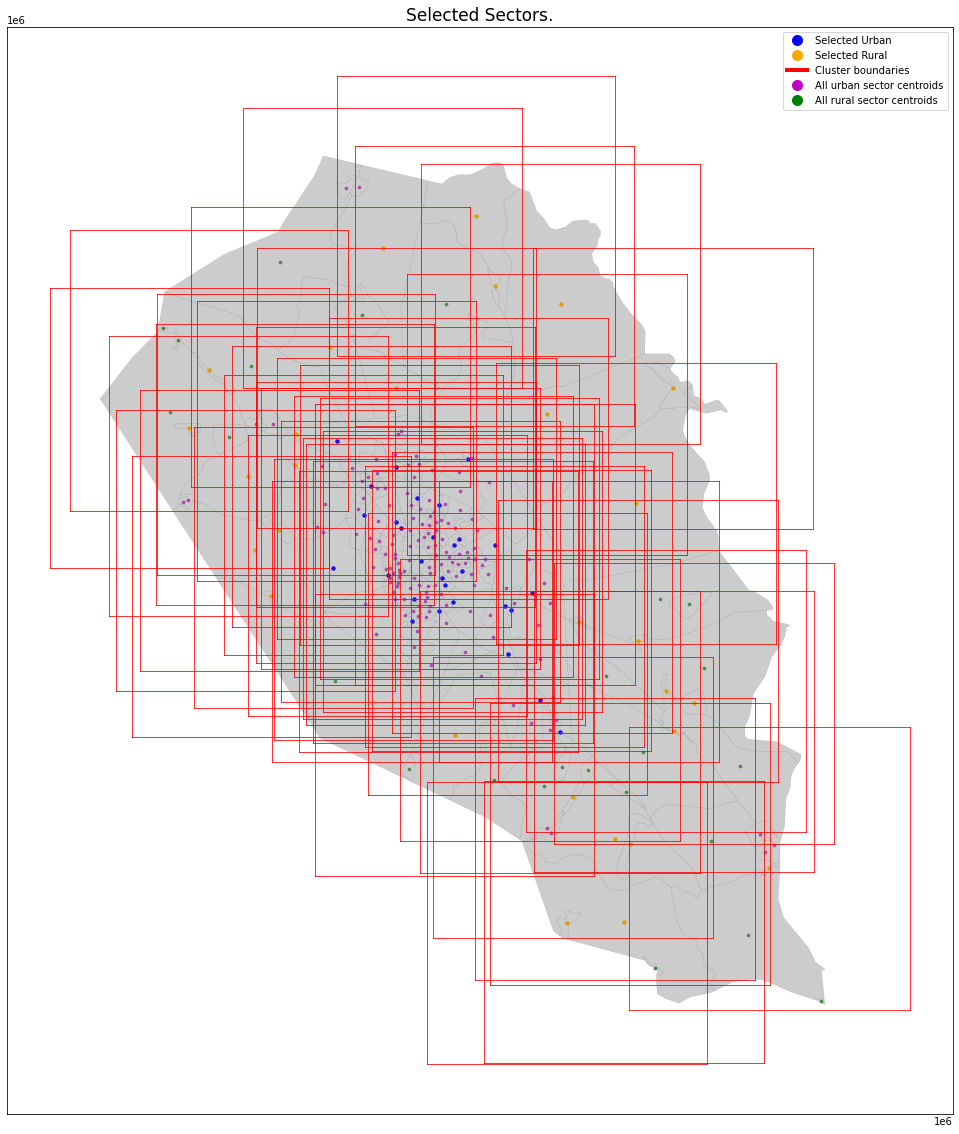

In [ ]:
plot_municipality_selected_sectors(geo, dataset, 2700300, True, True)

In [ ]:
plot_selected(geo, dataset)

NameError: ignored

Agora, devemos analisar se os setores selecionados não estão muito próximos um do outro, checando o caso de cada município.

- No caso de municípios em que não seja possível remover os overlaps e eles sejam pequenos, seguir com a seleção;
- Caso o overlap seja muito significativo, tratar como um único cluster, fazendo a média dos indicadores dos setores que compõem aquele cluster;
    *   opção 1: não alterar a quantidade de rurais que são selecionados, considerando que o desbalanceamento entre urbano/rural não será tão grande no final
    *   opção 2: tentar encaixar o máximo de clusters urbanos para setores agrupados, diminuindo o desbalanceamento
- Tentar pegar clusters que englobem uma boa parte do municipio

In [5]:
print("GitHub test")

GitHub test
